In [233]:
import numpy as np
import scipy as sp
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import tabulate
from tabulate import tabulate
import pandas as pd
import pyarrow as pa

### Part A

Welcome to our notebook for the vegitarian chief project. We are Jacob Moxley and Julio Leon, students in the Chemical Engineering department at CU Boulder. Jacob was primarily responsible for the coding parts of this project and Julio was primarily responsible for the write up.

### Part B

We begin with the entire transient heat conduction equation in radial coordinates:
$$\frac{\delta T}{\delta t} = \alpha \nabla^2 T = \alpha[\frac{1}{r} \frac{\delta}{\delta r}(r \frac{\delta T}{\delta r}) + \frac{1}{r^2} \frac{\delta^2 T}{\delta \theta^2} + \frac{\delta^2 T}{\delta z^2}]$$
We can now simpify the equation using the problem statement and some assumptions. We are going to assume a constant heat transfer coeffient and uniform step size in the time and radial dimenisions respectively. Now we are going to use the problem statement to state that the carrot acts as a long cylinder which means we are going to neglect heat transfer in the axial direction and anziotropic heat conduction which means that with a uniform hot water bath we can expect that there will be 0 temperature gradient along the theta direction which means that we can get the equation:
$$\frac{\delta T}{\delta t} = \alpha[\frac{\delta^2 T}{\delta r^2} + \frac{1}{r} (\frac{\delta T}{\delta r})]$$
from here we should replace the left side of the above equation with a two point forward difference approximation for time, and the right side of the equation with 3 point central difference approximations for the first and second derivatives. The function named centralDifCoef below will output the coefients for a central finite difference approximation for an given derivative, and order of convergence. The 3 point method listed in the problem statement has a second order of convergence, but as we will show in the experimental design discussion this is likely insuffient for the radial approximation which means our bottleneck for accuracy can likely be improved by using more points for our radial approximations. 

In [4]:
#returns the coef for evenly spaced points with central finite difference method
def centralDifCoef(derivative, order):
    p = int((2* np.floor((derivative+1)/2) -2 +order)/2)
    A = np.zeros((2*p+1, 2*p+1))
    A[0] = 1
    for i in range(1, 2*p+1):
        for j in range(0, p):
            A[i,j] = (-1*p + j)**i
        temp = p-1
        for j in range(p+1, 2*p+1):
            A[i,j] = (p-temp)**i
            temp = temp - 1
    
    b = np.zeros(2*p+1)
    b[derivative] = np.math.factorial(derivative)
    c = np.linalg.solve(A,b)
    return c

In [7]:
print(centralDifCoef(1,2))
print(centralDifCoef(2,2))

[-0.5  0.   0.5]
[ 1. -2.  1.]


We can now replace the the differentials in the simplified equation with the following where the radial steps are indexed by i and the time steps are indexed by n:
$$\frac{T_i^{n+1}-T_i^n}{\Delta t} = \alpha \cdot (\frac{T_{i-1}^n - 2\cdot T_i^n + T_{i+1}^n}{\Delta r^2} + \frac{1}{r_i} \cdot (\frac{T_{i-1}^n - T_{i+1}^n}{2 \cdot \Delta r}))$$
We now set $d = \frac{\alpha \Delta t}{\Delta r^2}$ and $c = \frac{\alpha \Delta t}{2 \Delta r}$ for notational convience
so the final expression we can use to solve for points iteratively is:
$$T_i^{n+1} = T_i^n + d \cdot (T_{i-1}^n-2 \cdot T_i^n + T_{i+1}^n) + \frac{c}{r_i} \cdot (T_{i-1}^n - T_{i+1}^n)$$
it is now important to note that our steps are considered from the outside moving in, i.e. $T_{5}^2$ is the temperature at 5 steps in from the ghost node towards the center of the carrot at the second time step

In [137]:
def timeStep(previous, alpha, deltaT, deltaR, radius):
    leftShift = previous[1:] #This is done in vector notation so that we can run it in parellel to make the best use of LAPACK
    leftShift = np.append(leftShift,0)
    rightShift = previous[0:-1]
    rightShift = np.insert(rightShift,0,0)
    nextStep = previous + (alpha*deltaT)/deltaR**2 * (rightShift - 2*previous + leftShift) + (alpha*deltaT/(2*deltaR*radius))*\
    (rightShift - leftShift)
    nextStep[0] = (50*(373-nextStep[1]) *deltaR/0.569) + nextStep[1]  #set boundary conditions that hold for any time
    nextStep[-1] = nextStep[-2] #this is the inner BC we set flux equal to 0 so the GN is equal to the last point
    return(nextStep)

In [152]:
data = np.zeros((1,102)) #choosing to use 100 points in the carrot, plus 2 ghost nodes
data[:] = 277
data[0,0] = 373
alpha = 0.569/(1029*3801)
deltaT = 10**-2
deltaR = 0.0075/100
radius = np.linspace(0.0075*1.01,0,102)
radius[-1] = 1 #this is a dummy value for the ghost node in the center which is delt with via the BC in the above function
previous = data[0,:]
for i in range(0,16):
    for j in range(0,6000):
        nex = timeStep(previous, alpha, deltaT, deltaR, radius)
        data = np.vstack((data,nex))
        previous = nex
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [163]:
for i in range(60000,90000):
    if data[i,-1] >= 358:
        print("index is:", i, "center temperature is:", data[i,-1])
        break

index is: 68648 center temperature is: 358.0004102195146


For problem E we just need to change the intial value and the BC for the outer ghost node

In [245]:
data = pd.read_csv('partD.csv', header = None)

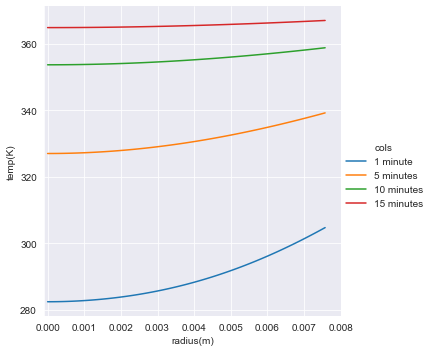

In [253]:
radius = np.linspace(0.0075*1.01,0,102)
df1 = pd.DataFrame({'radius(m)':radius, '1 minute': data.iloc[6000], '5 minutes': data.iloc[30000], '10 minutes': data.iloc[60000],\
                   '15 minutes': data.iloc[90000]})
df1 = df1.melt('radius(m)', var_name = 'cols', value_name = 'temp(K)')
sns.set_style('darkgrid')
g = sns.relplot(data = df1, x = 'radius(m)', y = 'temp(K)', hue = 'cols', kind = 'line')
axes = plt.gca()
axes.set_xlim([-0.0001,0.008])
plt.show()

### part E

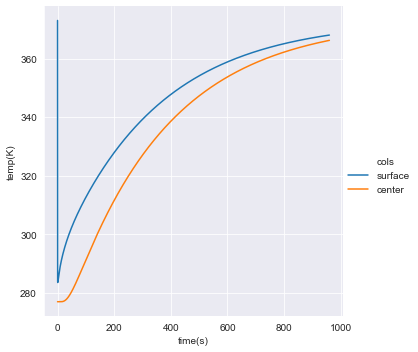

In [252]:
time = np.linspace(0,16*60,96001)
df2 = pd.DataFrame({'time(s)':time, 'surface':data.iloc[:,0], 'center':data.iloc[:,-1]})
df2 = df2.melt('time(s)', var_name = 'cols', value_name = 'temp(K)')
sns.set_style('darkgrid')
g = sns.relplot(data = df2, x = 'time(s)', y = 'temp(K)', hue = 'cols', kind = 'line')
plt.show()

### Part F

In [169]:
def timeStepBoulder(previous, alpha, deltaT, deltaR, radius):
    leftShift = previous[1:] #This is done in vector notation so that we can run it in parellel to make the best use of LAPACK
    leftShift = np.append(leftShift,0)
    rightShift = previous[0:-1]
    rightShift = np.insert(rightShift,0,0)
    nextStep = previous + (alpha*deltaT)/deltaR**2 * (rightShift - 2*previous + leftShift) + (alpha*deltaT/(2*deltaR*radius))*\
    (rightShift - leftShift)
    nextStep[0] = (50*(368-nextStep[1]) *deltaR/0.569) + nextStep[1]  #set boundary conditions that hold for any time
    nextStep[-1] = nextStep[-2] #this is the inner BC we set flux equal to 0 so the GN is equal to the last point
    return(nextStep)

In [176]:
dataBoulder = np.zeros((1,102)) #choosing to use 100 points in the carrot, plus 2 ghost nodes
dataBoulder[:] = 277
dataBoulder[0,0] = 368
alpha = 0.569/(1029*3801)
deltaT = 10**-2
deltaR = 0.0075/100
radius = np.linspace(0.0075*1.01,0,102)
radius[-1] = 1 #this is a dummy value for the ghost node in the center which is delt with via the BC in the above function
previous = dataBoulder[0,:]
for i in range(0,16):
    for j in range(0,6000):
        nex = timeStepBoulder(previous, alpha, deltaT, deltaR, radius)
        dataBoulder = np.vstack((dataBoulder,nex))
        previous = nex

In [177]:
for i in range(60000,90000):
    if dataBoulder[i,-1] >= 358:
        print("index is:", i, "center temperature is:", dataBoulder[i,-1])
        break

index is: 80795 center temperature is: 358.0001600184565


In [178]:
def timeStepSalt(previous, alpha, deltaT, deltaR, radius):
    leftShift = previous[1:] #This is done in vector notation so that we can run it in parellel to make the best use of LAPACK
    leftShift = np.append(leftShift,0)
    rightShift = previous[0:-1]
    rightShift = np.insert(rightShift,0,0)
    nextStep = previous + (alpha*deltaT)/deltaR**2 * (rightShift - 2*previous + leftShift) + (alpha*deltaT/(2*deltaR*radius))*\
    (rightShift - leftShift)
    nextStep[0] = (50*(378-nextStep[1]) *deltaR/0.569) + nextStep[1]  #set boundary conditions that hold for any time
    nextStep[-1] = nextStep[-2] #this is the inner BC we set flux equal to 0 so the GN is equal to the last point
    return(nextStep)

In [179]:
dataSalt = np.zeros((1,102)) #choosing to use 100 points in the carrot, plus 2 ghost nodes
dataSalt[:] = 277
dataSalt[0,0] = 378 #our IC has changed
alpha = 0.569/(1029*3801)
deltaT = 10**-2
deltaR = 0.0075/100
radius = np.linspace(0.0075*1.01,0,102)
radius[-1] = 1 #this is a dummy value for the ghost node in the center which is delt with via the BC in the above function
previous = dataSalt[0,:]
for i in range(0,16):
    for j in range(0,6000):
        nex = timeStepSalt(previous, alpha, deltaT, deltaR, radius)
        dataSalt = np.vstack((dataSalt,nex))
        previous = nex

In [180]:
for i in range(40000,90000):
    if dataSalt[i,-1] >= 358:
        print("index is:", i, "center temperature is:", dataSalt[i,-1])
        break

index is: 60471 center temperature is: 358.00009296981574


### Part G

Skinny data will be for a carrot of 75% the orginal diameter and fat data will be for 125%

In [185]:
dataSkinny = np.zeros((1,102)) #choosing to use 100 points in the carrot, plus 2 ghost nodes
dataSkinny[:] = 277
dataSkinny[0,0] = 373
alpha = 0.569/(1029*3801)
deltaT = 10**-2
deltaR = 0.005625/100
radius = np.linspace(0.005625*1.01,0,102)
radius[-1] = 1 #this is a dummy value for the ghost node in the center which is delt with via the BC in the above function
previous = dataSkinny[0,:]
for i in range(0,16):
    for j in range(0,6000):
        nex = timeStep(previous, alpha, deltaT, deltaR, radius)
        dataSkinny = np.vstack((dataSkinny,nex))
        previous = nex

In [188]:
for i in range(40000,90000):
    if dataSkinny[i,-1] >= 358:
        print("index is:", i, "center temperature is:", dataSkinny[i,-1])
        break

index is: 48718 center temperature is: 358.0001207733858


In [192]:
dataFat = np.zeros((1,102)) #choosing to use 100 points in the carrot, plus 2 ghost nodes
dataFat[:] = 277
dataFat[0,0] = 373
alpha = 0.569/(1029*3801)
deltaT = 10**-2
deltaR = 0.009375/100
radius = np.linspace(0.009375*1.01,0,102)
radius[-1] = 1 #this is a dummy value for the ghost node in the center which is delt with via the BC in the above function
previous = dataFat[0,:]
for i in range(0,16):
    for j in range(0,6000):
        nex = timeStep(previous, alpha, deltaT, deltaR, radius)
        dataFat = np.vstack((dataFat,nex))
        previous = nex

In [198]:
for i in range(40000,96000):
    if dataFat[i,-1] >= 358:
        print("index is:", i, "center temperature is:", dataFat[i,-1])
        break

index is: 90378 center temperature is: 358.0003176722011


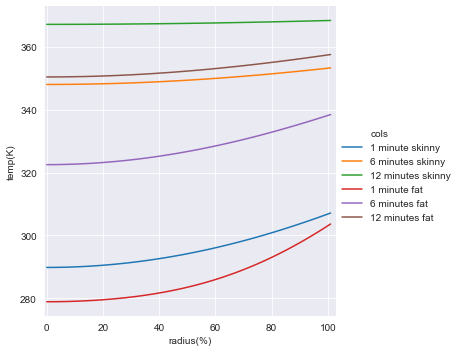

In [259]:
radius = np.linspace(101,0,102)
dataSkinny = pd.DataFrame(dataSkinny)
dataFat = pd.DataFrame(dataFat)
df3 = pd.DataFrame({'radius(%)':radius, '1 minute skinny': dataSkinny.iloc[6000], '6 minutes skinny': dataSkinny.iloc[36000],\
                   '12 minutes skinny': dataSkinny.iloc[72000], '1 minute fat': dataFat.iloc[6000], '6 minutes fat': dataFat.iloc[36000],\
                   '12 minutes fat': dataFat.iloc[72000]})
df3 = df3.melt('radius(%)', var_name = 'cols', value_name = 'temp(K)')
sns.set_style('darkgrid')
g = sns.relplot(data = df3, x = 'radius(%)', y = 'temp(K)', hue = 'cols', kind = 'line')
axes = plt.gca()
axes.set_xlim([-1,103])
plt.show()

### Part H

In [200]:
def timeStepBoil(previous, alpha, deltaT, deltaR, radius):
    leftShift = previous[1:] #This is done in vector notation so that we can run it in parellel to make the best use of LAPACK
    leftShift = np.append(leftShift,0)
    rightShift = previous[0:-1]
    rightShift = np.insert(rightShift,0,0)
    nextStep = previous + (alpha*deltaT)/deltaR**2 * (rightShift - 2*previous + leftShift) + (alpha*deltaT/(2*deltaR*radius))*\
    (rightShift - leftShift)
    nextStep[0] = (1000*(373-nextStep[1]) *deltaR/0.569) + nextStep[1]  #BC changes so we increase heat flux
    nextStep[-1] = nextStep[-2] #this is the inner BC we set flux equal to 0 so the GN is equal to the last point
    return(nextStep)

In [201]:
dataBoil = np.zeros((1,102)) #choosing to use 100 points in the carrot, plus 2 ghost nodes
dataBoil[:] = 277
dataBoil[0,0] = 373
alpha = 0.569/(1029*3801)
deltaT = 10**-2
deltaR = 0.0075/100
radius = np.linspace(0.0075*1.01,0,102)
radius[-1] = 1 #this is a dummy value for the ghost node in the center which is delt with via the BC in the above function
previous = dataBoil[0,:]
for i in range(0,16):
    for j in range(0,6000):
        nex = timeStepBoil(previous, alpha, deltaT, deltaR, radius)
        dataBoil = np.vstack((dataBoil,nex))
        previous = nex

In [206]:
for i in range(10000,50000):
    if dataBoil[i,-1] >= 358:
        print("index is:", i, "center temperature is:", dataBoil[i,-1])
        break

index is: 17974 center temperature is: 358.0002175988042


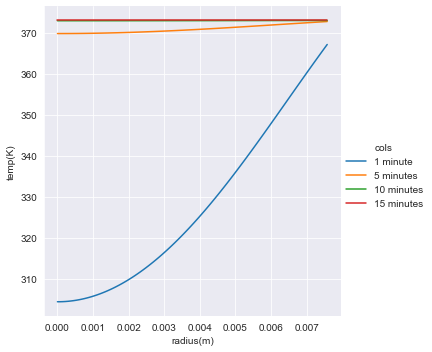

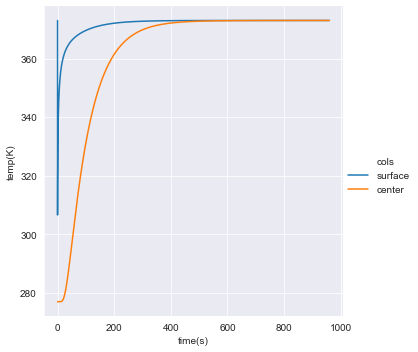

In [265]:
dataBoil = pd.DataFrame(dataBoil)
radius = np.linspace(0.0075*1.01,0,102)
df4 = pd.DataFrame({'radius(m)':radius, '1 minute': dataBoil.iloc[6000], '5 minutes': dataBoil.iloc[30000],\
                    '10 minutes': dataBoil.iloc[60000], '15 minutes': dataBoil.iloc[90000]})
df4 = df4.melt('radius(m)', var_name = 'cols', value_name = 'temp(K)')
sns.set_style('darkgrid')
g1 = sns.relplot(data = df4, x = 'radius(m)', y = 'temp(K)', hue = 'cols', kind = 'line')

time = np.linspace(0,960,96001)
df5 = pd.DataFrame({'time(s)': time, 'surface': dataBoil.iloc[:,0], 'center': dataBoil.iloc[:,-1]})
df5 = df5.melt('time(s)', var_name = 'cols', value_name = 'temp(K)')
sns.set_style('darkgrid')
g2 = sns.relplot(data = df5, x = 'time(s)', y = 'temp(K)', hue = 'cols', kind = 'line')

plt.show()

#### Biggest question I've got for the time being is how to deal with the central BC. We can introduce the outer ghost node in the radial direction as the 0th point and then set it equal to the ambient temperature of the water, 100C. I am not sure how to do the same thing for the center. The IC is that T(r,t = 0) = 4C for all r

a discussion on analog sample rates for thermocouples:
https://www.embedded.com/sampling-rates-for-analog-sensors/
an example of an inexpensive thermoresistor that can be used with an RPi or Ardunio.
https://www.adafruit.com/product/372
The key point here is that it is completely realistic to expect sample sizes on the order of $O(10^{-6})-O(10^{-4})$ seconds depending on the clock rate of our controller and with a bit of smoothing we can expect good accuracy. With some work we can probably get this at least a couple of orders of magnitude lower, because most wire formats are capable of transmitting at least 1Mbit/s which means getting a 16 bit sample in under 0.1ms should be no problem as a default. If we want 1Gbit/s we can likely use a LAN hookup and then translate the wire format in the controller which would give us 16 bits in under $0.1 \mu s$. We can look at I2C data transfer rates and see that we will not be bottlenecked by our wire format for this type of application. This means we can expect the number of significant digits in the temperature readings to come from the resistor. To gather experimental data to see if our readings are correct the best way I can think of right now is to take a paddle bit and drill out the center of the carrot and then stick our thermocouple to the inside of the cylinder. This means that our experimental data will be constrained by the accuracy of the calaper that we use to measure the thickness of the carrot, and how many different sized paddle bits we can find. We are going to be lucky if we can get millimeter precison here, likely we will have $O(10^{-3})-O(10^{-2})$ meter precision here. Using our current methods with a 2 point forward difference approximation for time and a 3 point central difference method for radius we can see that the error is bounded above by $O(\Delta t) + O(\Delta r^2)$ which means that we expect that it will be easier to design this experiment in a way where the error from the radial term dominates. This is easy to remidy by using a higher order central difference method for the interior points such as a 5 point method which will result in 4th order convergence. At any level of desired accuracy we should probably use a finite difference method with 3 time faster convergence for the radial term vs. the time term.

In [8]:
print(centralDifCoef(1,4))
print(centralDifCoef(2,4))

[ 0.08333333 -0.66666667  0.          0.66666667 -0.08333333]
[-0.08333333  1.33333333 -2.5         1.33333333 -0.08333333]


In [172]:
#pd.DataFrame(data).to_csv('partD.csv', header = False, index = False)

In [181]:
#pd.DataFrame(dataBoulder).to_csv('partFBoulder.csv', header = False, index = False)

In [182]:
#pd.DataFrame(dataSalt).to_csv('partFSalt.csv', header = False, index = False)

In [186]:
#pd.DataFrame(dataSkinny).to_csv('partGSkinny.csv', header = False, index = False)

In [199]:
#pd.DataFrame(dataFat).to_csv('partGFat.csv', header = False, index = False)

In [207]:
#pd.DataFrame(dataBoil).to_csv('partH.csv', header = False, index = False)